In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        #self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        #self.linear = nn.Linear(self.H_no, 1)
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        W_clust = F.softmax(self.clust_raw/temp, 0)
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 10
layer_no = 1
sub_no = 5
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5972


In [7]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0
print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, _ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, loss.item())


[0.31622777 0.28117687 0.25001104 0.22229965 0.19765981 0.17575106
 0.1562707  0.13894955 0.12354829 0.10985411 0.09767781 0.08685114
 0.0772245  0.06866488 0.06105402 0.05428675 0.04826957 0.04291934
 0.03816213 0.03393222 0.03017115 0.02682696 0.02385344 0.02120951
 0.01885863 0.01676833 0.01490972 0.01325711 0.01178769 0.01048113
 0.0093194  0.00828643 0.00736795 0.00655129 0.00582514 0.00517947
 0.00460538 0.00409492 0.00364103 0.00323746 0.00287862 0.00255955
 0.00227585 0.00202359 0.00179929 0.00159986 0.00142253 0.00126486
 0.00112466 0.001     ]


<ipython-input-7-6e81a2938f7b>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.0019504427909851074 0.04774051532149315 0.00036138296127319336 0.08807206898927689
0.31622776601683794
49 0.04845231771469116 0.026102449744939804 0.04426443576812744 0.027579329907894135
0.28117686979742307
99 0.1126471757888794 0.02415916882455349 0.10984992980957031 0.03003077022731304
0.250011038261793
149 0.26086878776550293 0.02020939625799656 0.2386133074760437 0.020090866833925247
0.22229964825261944
199 0.2780134677886963 0.01967521570622921 0.21274930238723755 0.02113097533583641
0.19765980717016338
249 0.28192025423049927 0.019626598805189133 0.21881729364395142 0.018698036670684814
0.1757510624854792
299 0.28506821393966675 0.019443824887275696 0.23974692821502686 0.024340009316802025
0.15627069765469953
349 0.28621435165405273 0.0194204431027174 0.23682934045791626 0.021959180012345314
0.13894954943731375
399 0.2884477376937866 0.01942153461277485 0.2736052870750427 0.019001418724656105
0.12354828882567469
449 0.29193681478500366 0.01926049217581749 0.22980940341949463

4249 0.4243123531341553 0.015726972371339798 0.39373135566711426 0.015703676268458366
4299 0.4196845293045044 0.016040420159697533 0.439014196395874 0.01926911249756813
4349 0.37755030393600464 0.016928356140851974 0.47874176502227783 0.01742670126259327
4399 0.43203866481781006 0.015489491634070873 0.397488534450531 0.01657787710428238
4449 0.4277299642562866 0.015567164868116379 0.4243430495262146 0.013933077454566956
4499 0.4407777786254883 0.01526916678994894 0.37794697284698486 0.016097158193588257
4549 0.44073861837387085 0.01542509812861681 0.30462485551834106 0.02041435055434704
4599 0.45456790924072266 0.014833868481218815 0.31632816791534424 0.016389470547437668
4649 0.46799135208129883 0.014480514451861382 0.4213091731071472 0.01498815044760704
4699 0.4752151370048523 0.014327836222946644 0.2661442756652832 0.01939920149743557
4749 0.45993661880493164 0.014828168787062168 0.3869510889053345 0.015098471194505692
4799 0.4798891544342041 0.01415916346013546 0.4551922678947449 0

KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_l1_h10_model.pt")

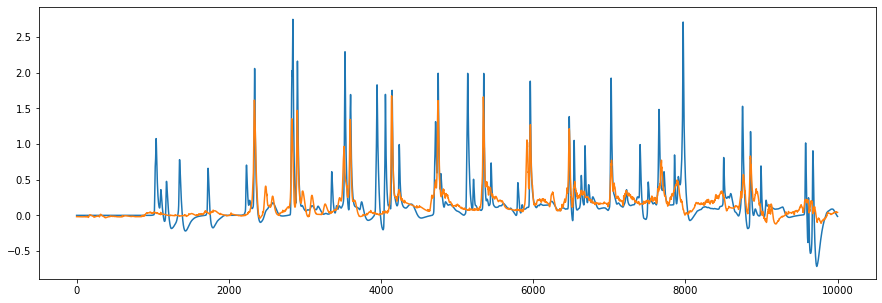

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

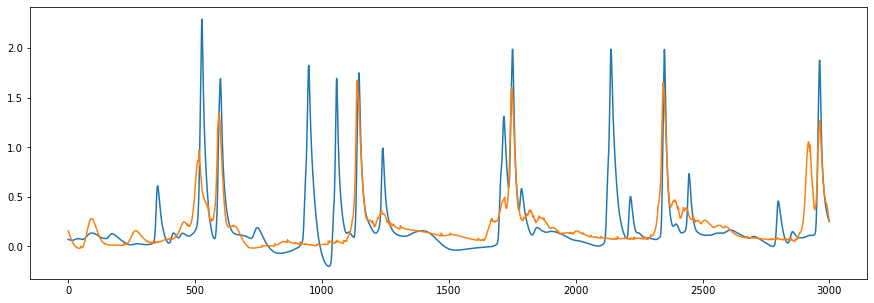

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

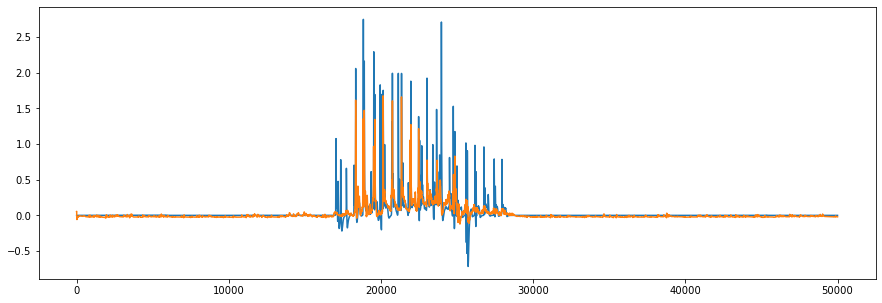

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [11]:
raw = model.clust_raw
syn = torch.zeros(raw.shape[1])
for i in range(syn.shape[0]):
    idx = torch.argmax(raw[:,i])
    syn[i] = idx
    
C_syn = syn.cpu().detach().numpy()
true = eloc[e_idx,0]

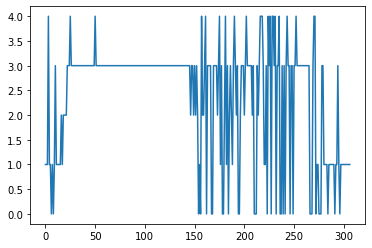

In [12]:
plt.plot(C_syn)

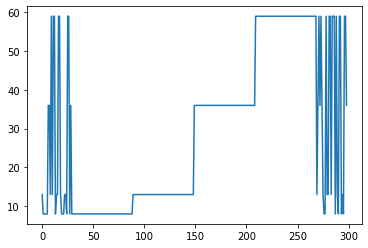

In [13]:
plt.plot(true)

In [29]:
raw = model.clust_raw
soft = F.softmax(raw/0.001, 0).cpu().detach().numpy()

In [30]:
print(np.where(soft == 1)[1].shape)

(307,)
